In [1]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

In [20]:
from data import Dataloader
from models_copy import TwoClustersMIP
import metrics

In [21]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()


In [22]:
# Let's train an example model
model = TwoClustersMIP(5,2)
#print(model.seed) # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

TypeError: BaseModel.__init__() takes 1 positional argument but 3 were given

In [ ]:
#model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
#model.fit(X, Y) 

In [19]:
print(model.criteria,sep = '\n')

[[[<gurobi.Var u_000 (value 0.0)>, <gurobi.Var u_001 (value 0.0)>], [<gurobi.Var u_010 (value 0.001)>, <gurobi.Var u_011 (value 0.001)>], [<gurobi.Var u_020 (value 0.002)>, <gurobi.Var u_021 (value 0.002)>], [<gurobi.Var u_030 (value 0.003)>, <gurobi.Var u_031 (value 0.003)>], [<gurobi.Var u_040 (value 0.004)>, <gurobi.Var u_041 (value 0.004)>], [<gurobi.Var u_050 (value 0.985)>, <gurobi.Var u_051 (value 0.985)>]], [[<gurobi.Var u_100 (value 0.0)>, <gurobi.Var u_101 (value 0.0)>], [<gurobi.Var u_110 (value 0.001)>, <gurobi.Var u_111 (value 0.001)>], [<gurobi.Var u_120 (value 0.002)>, <gurobi.Var u_121 (value 0.002)>], [<gurobi.Var u_130 (value 0.003)>, <gurobi.Var u_131 (value 0.003)>], [<gurobi.Var u_140 (value 0.004)>, <gurobi.Var u_141 (value 0.004)>], [<gurobi.Var u_150 (value 0.005)>, <gurobi.Var u_151 (value 0.005)>]], [[<gurobi.Var u_200 (value 0.0)>, <gurobi.Var u_201 (value 0.0)>], [<gurobi.Var u_210 (value 0.001)>, <gurobi.Var u_211 (value 0.001)>], [<gurobi.Var u_220 (value 

In [7]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
model.predict_utility(X)
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[ 1.33126692e-04  1.33126692e-04]
 [ 1.43040541e-01  1.43040541e-01]
 [ 4.46851754e-01  4.46851754e-01]
 [-1.45636017e-03 -1.45636017e-03]
 [-4.49836258e-01 -4.49836258e-01]]


In [8]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]]


In [9]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.4


In [10]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.519
Percentage of explained preferences for all samples: 0.519


In [11]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 0 0]


In [12]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [13]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.49974987493746875
Cluster intersection for all samples: 0.49974987493746875


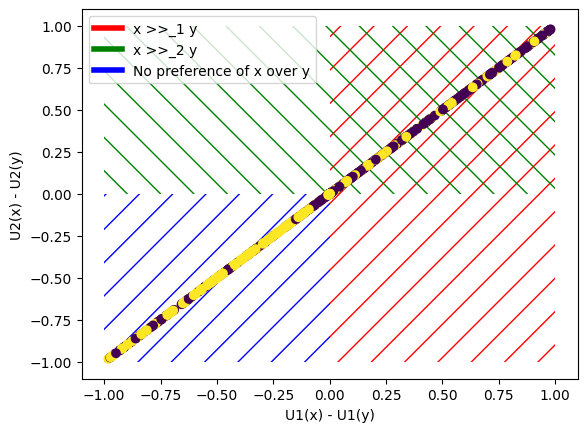

In [14]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [ ]:
# This cell should work when you have completed the TwoClustersMIP model
from models import TwoClustersMIP

parameters = {"n_pieces": 5, "n_clusters": 2} # Can be completed
model = TwoClustersMIP(**parameters)
model.fit(X, Y)

# Uncomment once your model is working
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

[[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [3.82003667e-04 2.30327233e-05 1.63227181e-03 3.51066072e-04]]
[[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [3.82003667e-04 2.30327233e-05 1.63227181e-03 3.51066072e-04]]
[[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [3.82003667e-04 2.30327233e-05 1.63227181e-03 3.51066072e-04]]
[[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [3.82003667e-04 2.30327233e-05 1.63227181e-03 3.51066072e-04]]
[[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [3.82003667e-04 2.30327233e-05 1.63227181e-03 3.51066072e-04]]
[[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [3.82003667e-04 2.30327233e-05 1.63227181e-03 3.51066072e-04]]
[[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [3.82003667e-04 2.30327233e-05 1.63227181e-03 3.51066072e-04]]
[[2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [3.82003667e-04 2.30327233e-05 1.63227181e-03 3

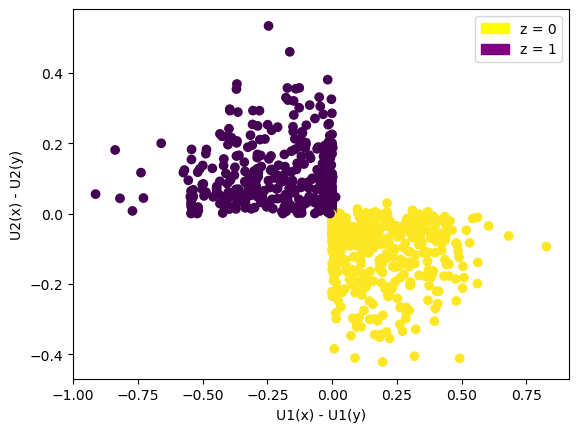

In [ ]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find a model that will work well with larger data instances.